In [63]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau
from skimage.measure import compare_ssim as ssim
import random
import time
from models.models import ConvLSTM, PhyCell, EncoderRNN
from data.moving_mnist import MovingMNIST
from constrain_moments import K2M
import argparse
from pathlib import Path

In [64]:
device = torch.cuda.current_device()

In [65]:
from fastai.vision.all import show_images

In [66]:
batch_size=64
n_frames = 5

In [67]:
path = Path.cwd()/'data'

In [68]:
mm = MovingMNIST(root=path, is_train=True, n_frames_input=n_frames, n_frames_output=n_frames, num_objects=[2])
train_loader = torch.utils.data.DataLoader(dataset=mm, batch_size=batch_size, shuffle=True, num_workers=8)

In [ ]:
len(mm)

In [88]:
tmm = MovingMNIST(root=path, is_train=True, n_frames_input=n_frames, n_frames_output=n_frames, num_objects=[2])
test_loader  = torch.utils.data.DataLoader(dataset=tmm, batch_size=1, shuffle=False, num_workers=8)

some fastai magic

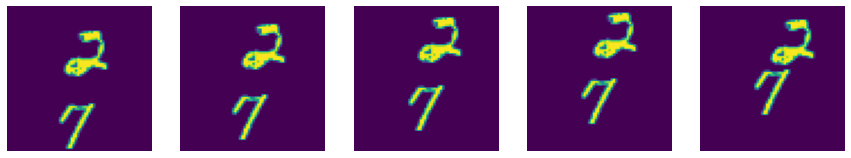

In [92]:
show_images(mm[4][1])

In [93]:
constraints = torch.zeros((49,7,7)).to(device)
ind = 0
for i in range(0,7):
    for j in range(0,7):
        constraints[ind,i,j] = 1
        ind +=1    

In [94]:
def train_on_batch(input_tensor, target_tensor, encoder, encoder_optimizer, criterion,teacher_forcing_ratio):                
    encoder_optimizer.zero_grad()
    # input_tensor : torch.Size([batch_size, input_length, 1, 64, 64])
    input_length  = input_tensor.size(1)
    target_length = target_tensor.size(1)
    loss = 0
    for ei in range(input_length-1): 
        encoder_output, encoder_hidden, output_image,_,_ = encoder(input_tensor[:,ei,:,:,:], (ei==0) )
        loss += criterion(output_image,input_tensor[:,ei+1,:,:,:])

    decoder_input = input_tensor[:,-1,:,:,:] # first decoder input = last image of input sequence
    
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False 
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, output_image,_,_ = encoder(decoder_input)
            target = target_tensor[:,di,:,:,:]
            loss += criterion(output_image,target)
            decoder_input = target 
         
    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, output_image,_,_ = encoder(decoder_input)
            decoder_input = output_image
            target = target_tensor[:,di,:,:,:]
            loss += criterion(output_image, target)
 
    # Moment Regularisation  encoder.phycell.cell_list[0].F.conv1.weight # size (nb_filters,in_channels,7,7)
    k2m = K2M([7,7]).to(device)
    for b in range(0,encoder.phycell.cell_list[0].input_dim):
        filters = encoder.phycell.cell_list[0].F.conv1.weight[:,b,:,:] # (nb_filters,7,7)
        
        m = k2m(filters.double()) 
        m  = m.float()   
        loss += criterion(m, constraints) # constrains is a precomputed matrix   
    loss.backward()
    encoder_optimizer.step()
    return loss.item() / target_length

In [95]:
from fastprogress import progress_bar, master_bar

In [96]:
def trainIters(encoder, n_epochs, print_every,eval_every):
    start = time.time()
    train_losses = []
    best_mse = float('inf')

    encoder_optimizer = torch.optim.Adam(encoder.parameters(),lr=0.0001)
    scheduler_enc = ReduceLROnPlateau(encoder_optimizer, mode='min', patience=3,factor=0.5,verbose=True)
    criterion = nn.MSELoss()
    
    mb = master_bar(range(0, n_epochs ))
    for epoch in mb:
        t0 = time.time()
        loss_epoch = 0
        teacher_forcing_ratio = np.maximum(0 , 1 - epoch * 0.01)
        
        for i, out in progress_bar(list(enumerate(train_loader, 0)), parent=mb):
            #input_batch =  torch.Size([8, 20, 1, 64, 64])
            input_tensor = out[1].to(device)
            target_tensor = out[2].to(device)
            loss = train_on_batch(input_tensor, target_tensor, encoder, encoder_optimizer, criterion, teacher_forcing_ratio)                                   
            loss_epoch += loss
            
        if (i%10)==0 :
            print(i, '/', len(train_loader) , ' loss= ' , loss)
            
        train_losses.append(loss_epoch)        
        if (epoch+1) % print_every == 0:
            print('epoch ',epoch,  ' loss ',loss_epoch , ' epoch time ',time.time()-t0)
            
        if (epoch+1) % eval_every == 0:
            mse, mae,ssim = evaluate(encoder,test_loader) 
            scheduler_enc.step(mse)                              
    return train_losses

In [102]:
def evaluate(encoder,loader):
    total_mse, total_mae,total_ssim,total_bce = 0,0,0,0
    with torch.no_grad():
        for i, out in enumerate(loader, 0):
            #input_batch = torch.Size([8, 20, 1, 64, 64])
            input_tensor = out[1].to(device)
            target_tensor = out[2].to(device)

            input_length = input_tensor.size()[1]
            target_length = target_tensor.size()[1]

            for ei in range(input_length-1):
                encoder_output, encoder_hidden, _,_,_  = encoder(input_tensor[:,ei,:,:,:], (ei==0))

            decoder_input = input_tensor[:,-1,:,:,:] # first decoder input= last image of input sequence
            predictions = []

            for di in range(target_length):
                decoder_output, decoder_hidden, output_image,_,_ = encoder(decoder_input, False, False)
                decoder_input = output_image
                predictions.append(output_image.cpu())

            input = input_tensor.cpu().numpy()
            target = target_tensor.cpu().numpy()
            predictions =  np.stack(predictions) # for MM: (10, batch_size, 1, 64, 64)
            predictions = predictions.swapaxes(0,1)  # (batch_size,10, 1, 64, 64)

            mse_batch = np.mean((predictions-target)**2 , axis=(0,1,2)).sum()
            mae_batch = np.mean(np.abs(predictions-target) ,  axis=(0,1,2)).sum() 
            total_mse += mse_batch
            total_mae += mae_batch
            
            for a in range(0,target.shape[0]):
                for b in range(0,target.shape[1]):
                    total_ssim += ssim(target[a,b,0,], predictions[a,b,0,]) / (target.shape[0]*target.shape[1]) 
            
            cross_entropy = -target*np.log(predictions) - (1-target) * np.log(1-predictions)
            cross_entropy = cross_entropy.sum()
            cross_entropy = cross_entropy / (batch_size*target_length)
            total_bce +=  cross_entropy
     
    print('eval mse ', total_mse/len(loader),  ' eval mae ', total_mae/len(loader),' eval ssim ',total_ssim/len(loader), ' eval bce ', total_bce/len(loader))        
    return total_mse/len(loader),  total_mae/len(loader), total_ssim/len(loader)

# Actual Training

In [115]:
n_epochs = 50
print_every = 1
eval_every = 10

In [116]:
phycell =  PhyCell(input_shape=(16,16), input_dim=64, F_hidden_dims=[49], n_layers=1, kernel_size=(7,7), device=device) 
convlstm =  ConvLSTM(input_shape=(16,16), input_dim=64, hidden_dims=[128,128,64], n_layers=3, kernel_size=(3,3), device=device)   
encoder = EncoderRNN(phycell, convlstm, device)

layer  0 input dim  64  hidden dim  128
layer  1 input dim  128  hidden dim  128
layer  2 input dim  128  hidden dim  64


In [117]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
   
print('phycell ' , count_parameters(phycell) )    
print('convlstm ' , count_parameters(convlstm) ) 
print('encoder ' , count_parameters(encoder) ) 

phycell  230833
convlstm  2508032
encoder  2951002


In [118]:
plot_losses = trainIters(encoder,n_epochs,print_every=print_every, eval_every=eval_every)
print(plot_losses)

epoch  0  loss  73.21658122539519  epoch time  69.31975364685059
epoch  1  loss  37.67594702243805  epoch time  69.87231993675232
epoch  2  loss  33.437412953376786  epoch time  69.8887107372284
epoch  3  loss  31.190967810153953  epoch time  69.84498405456543


Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fad170b04c0>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fad170b04c0>Traceback (most recent call last):

  File "/home/tcapelle/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fad170b04c0>Traceback (most recent call last):


  File "/home/tcapelle/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__
Traceback (most recent call last):
  File "/home/tcapelle/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1075, in _shutdown_workers
    self._shutdown_workers()  File "/home/tcapelle/miniconda3/envs/fastai/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1101, in __del__

      File "/home/tcapelle/miniconda3/env

epoch  4  loss  29.891718184947976  epoch time  70.34186029434204
epoch  5  loss  28.729369306564323  epoch time  69.71904492378235
epoch  6  loss  27.790680432319657  epoch time  69.7655668258667
epoch  7  loss  27.01770777702331  epoch time  69.78014755249023
epoch  8  loss  26.219197428226476  epoch time  69.72111511230469
epoch  9  loss  25.693059754371646  epoch time  69.91134333610535
eval mse  101.60418679409027  eval mae  203.78193783111573  eval ssim  0.7238655206132133  eval bce  7.379872168121356
epoch  10  loss  25.200044941902163  epoch time  69.54103970527649
epoch  11  loss  24.6808013677597  epoch time  69.79571890830994
epoch  12  loss  24.183830106258394  epoch time  69.96187376976013
epoch  13  loss  23.98239208459854  epoch time  69.82256507873535
epoch  14  loss  23.501499557495112  epoch time  69.99590516090393
epoch  15  loss  23.307202577590942  epoch time  69.9118857383728
epoch  16  loss  23.04002393484115  epoch time  69.65596389770508
epoch  17  loss  22.617